# Exercise 4: Markov state modeling
## Climate evolution on the geological time scale
At the link https://drive.google.com/file/d/1nMr4XdOXo3Xfs5zAJPczm7h0fXVwUsUl you can download a time series with the value of temperature as a function of time in 96 positions equally distributed on Earth. The time series has been generated with the model described in [Fraedrich K, et al 2005 The Planet Simulator: Towards a user friendly model. Meteorologische Zeitschrift 14, 299–304.] and covers a time span in which the Earth enters a few times in a Ice age.
Build a Markov State model from this time series

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from numba import njit
import os.path
import time
from scipy.spatial import distance_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
data = np.loadtxt('airT_dec5.txt', skiprows=0, unpack=True).T

npatt,nfeat=data.shape
print(data.shape)

(21578, 96)


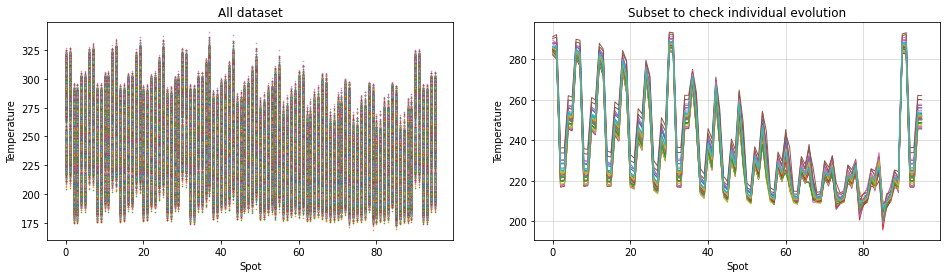

In [3]:
fig = plt.figure()
fig.set_size_inches(16,4)

ax =plt.subplot2grid((1,2), (0,0))
plt.ylabel('Temperature')
plt.xlabel('Spot')
plt.title('All dataset')
for i in range(len(data)):
    plt.plot(data[i],'o',markersize = 0.5)
    
ax =plt.subplot2grid((1,2), (0,1))
plt.ylabel('Temperature')
plt.xlabel('Spot')
plt.title('Subset to check individual evolution')
for i in range(10,40):
    plt.plot(data[i],linewidth=1)
plt.grid(alpha=0.5)

plt.show()

In [4]:
means=np.mean(data,axis=0)
stds=np.std(data,axis=0)
data=(data-means)/stds

1. Find the microstates by a cluster analysis performed with k-means or k-medoids. Optionally, perform a preliminary dimensional reduction using PCA

In [5]:
def draw(data,centroids,z,k,b,icount=0):
    data1=data[:,0]
    data2=data[:,1]
    
    plt.figure()
    for i in range(k):
        plt.plot(data1[np.where(z==i)],data2[np.where(z==i)],'.',label='%i'%i,markersize=1)
        if (b==0):
            plt.title('clustering initialization')
        else:
            plt.title('clustering at step %i'%icount)  
    plt.plot(centroids[:,0],centroids[:,1],'*k')

In [6]:
# function for k-means
# bplot=0 if you do not want plots, 1 otherwise
def kmeans(data,k,bplot=1):

    npatt,nfeat=data.shape
    
    # 1. randomly pick k centers
    centroids=np.zeros((k,nfeat))
    inds=np.random.choice(npatt,k,replace=False)
    for i in range(k):
        centroids[i,:]=data[inds[i],:]
        
    # 2. assign each point to its nearest center
    distances=distance_matrix(data,centroids)
    z=np.zeros(npatt) # column index of the min distance per row
    zold=np.zeros(npatt)
    z=np.argmin(distances,axis=1)      
    icount=0
    
    if (bplot==1):
        draw(data,centroids,z,k,b=0)
       
    while np.any(np.not_equal(z,zold)):
        zold=z
        # 3. update the k cluster centroids based on the assigned cluster membership
        for i in range(k):
            inds=np.where(z==i)
            centroids[i,:]=np.mean(data[inds,:],axis=1)
            
        distances=distance_matrix(data,centroids)
        z=np.argmin(distances,axis=1)
        icount+=1
        
        if (bplot==1):
            draw(data,centroids,z,k,b=1,icount=icount)
        
    obj=0
    for i in range(k):
        inds2=np.where(z==i)
        obj=obj+np.sum(np.linalg.norm(data[inds2,:]-centroids[i,:],axis=1)**2) 
            
    return z,centroids,obj

normalized eigenvalues:  [0.9513338  0.02674697 0.00865966 0.00756645] ...


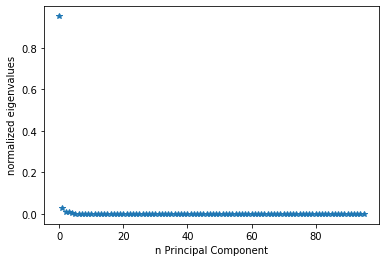

In [7]:
cov=np.cov(data.T)
eigvals,eigvecs=np.linalg.eigh(cov)

idx=eigvals.argsort()[::-1]   
eigvals=eigvals[idx]
eigvecs=eigvecs[:,idx]

neigvals=eigvals/np.sum(eigvals) # "normalized" eigenvalues
print('normalized eigenvalues: ',neigvals[:4],'...')

plt.plot(neigvals,'*')
#plt.yscale('log')
plt.xlabel('n Principal Component')
plt.ylabel('normalized eigenvalues')
plt.show()

In [8]:
nPCs=2
dataPCs=np.zeros((npatt,nPCs))

for i in range(npatt):
    for j in range(nPCs):
        dataPCs[i,j]=np.sum(data[i,:]*eigvecs[:,j])

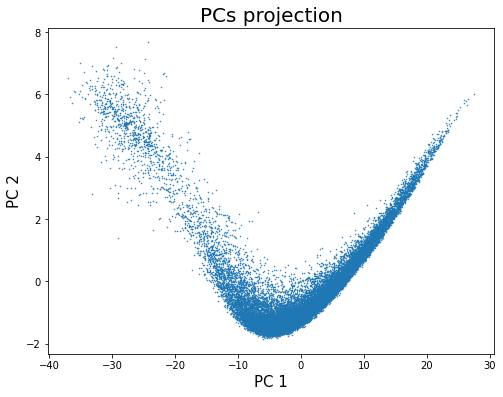

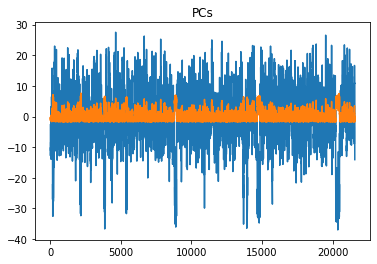

In [9]:
f=plt.figure(figsize=(8,6))

plt.title("PCs projection", fontsize=20)

plt.xlabel("PC 1", fontsize=15)
plt.ylabel("PC 2", fontsize=15)

plt.plot(dataPCs[:,0],dataPCs[:,1],'.',markersize=1)
plt.show()

plt.figure()
plt.plot(dataPCs)
plt.title('PCs')
plt.show()

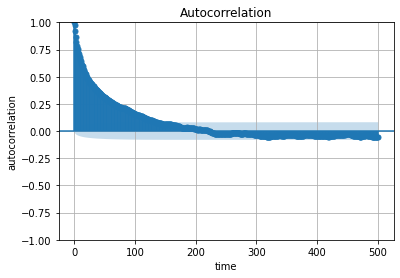

In [127]:
plot_acf(data[:,10],lags=500)
plt.grid(axis='both')
plt.xlabel('time')
plt.ylabel('autocorrelation')

plt.show()

In [134]:
ks=[5,10,20,30,50,100,200]
nk=np.size(ks)

zs=np.zeros((nk,npatt))
objs=np.zeros(nk)
icount=0

for k in ks:
    z,clusters,obj=kmeans(dataPCs,k,bplot=0)
    [zs[icount,:],objs[icount]]=[z,obj]
    icount+=1
    print(k)

5
10
20
30
50
100
200


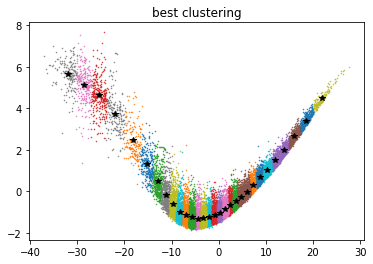

In [135]:
kopt=30 # how many clusters? as much as you can

#a=np.array(np.where(ks==kopt))
a=np.where(np.array(ks)==kopt)
z[:]=zs[a,:]

centroids=np.zeros((kopt,nPCs))
for i in range(kopt):
    inds2=np.where(z==i)
    centroids[i,:]=np.mean(dataPCs[inds2,:],axis=1)


plt.figure(figsize=(8,8))
draw(dataPCs,centroids,z,kopt,b=0)
plt.title('best clustering')
plt.show()

In [136]:
def orderClusters(centroids,labels):
    idx=centroids[:,0].argsort()
    labels=np.array(labels)
    newCentroids=centroids[idx]
    newLabels=np.zeros(len(labels),dtype=int)
    for i in range(len(labels)):
        newLabels[i]=int(np.where(idx==labels[i])[0])
    return newCentroids,newLabels

In [137]:
# order clusters
centroids,z=orderClusters(centroids,z)
idx=(centroids[:,0]).argsort()
order=np.arange(0,kopt)
order=order[idx]
print(order)
for i in range(npatt):
    z[i]=order[z[i]]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


2. choose a time lag τ , and estimate the transition matrix between each pair of clusters π_(α,β) = P (β, τ |α, 0)

n of times you visit each cluster:
 [ 165.  272.  298.  186.  171.  268.  401.  466.  676.  740.  849.  957.
 1074. 1177. 1154. 1150. 1100. 1042. 1083. 1088. 1046. 1104.  989.  913.
  869.  771.  600.  427.  349.  153.]
transition matrix:
 [[0.08484848 0.24242424 0.15151515 0.12727273 0.03030303 0.04242424
  0.04242424 0.01818182 0.03030303 0.         0.01212121 0.02424242
  0.01818182 0.01818182 0.03636364 0.06666667 0.00606061 0.01212121
  0.01212121 0.         0.         0.         0.01818182 0.
  0.00606061 0.         0.         0.         0.         0.        ]
 [0.11397059 0.19485294 0.17279412 0.09926471 0.04044118 0.04411765
  0.04044118 0.01838235 0.02205882 0.         0.01838235 0.01102941
  0.01838235 0.02941176 0.00367647 0.02941176 0.02205882 0.02205882
  0.01470588 0.01102941 0.00735294 0.00367647 0.00367647 0.01102941
  0.00735294 0.02205882 0.00735294 0.00735294 0.00367647 0.        ]
 [0.1409396  0.13422819 0.22483221 0.04362416 0.06040268 0.03355705
  0.04362416 0.020

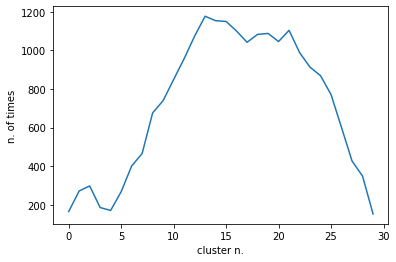

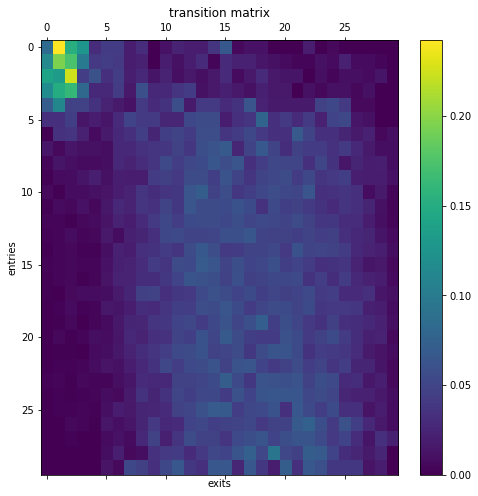

In [138]:
tau=40 # how to choose the optimal value for tau?
ndtimes=npatt-tau # i.e. how many steps t --> t+tau
trans=np.zeros((kopt,kopt)) # the transition matrix
ntimecl=np.zeros(kopt) # i.e. #(alpha), n. of times in clusters alpha

for i in range(ndtimes):
    trans[z[i],z[i+tau]]+=1
    ntimecl[z[i]]+=1
for i in range(kopt):
    trans[i,:]=trans[i,:]/ntimecl[i]

print('n of times you visit each cluster:\n',ntimecl)
plt.plot(ntimecl)
plt.xlabel('cluster n.')
plt.ylabel('n. of times')

print('transition matrix:\n',trans)
print('total probs:\n',np.sum(trans,axis=1)) # as a check

fig=plt.figure(figsize=(8,8))
matdraw=plt.matshow(trans,fignum=0,aspect='auto')
plt.title('transition matrix')
plt.xlabel('exits')
plt.ylabel('entries')
fig.colorbar(matdraw)
plt.show()

3. By analyzing the spectrum choose an appropriate number of Markov states. Find the Markov states by inspecting the sign of the eigenvectors.

[ 1.        +0.j          0.57953102+0.j          0.05662441+0.j
  0.03654586+0.03224135j  0.03654586-0.03224135j -0.0459903 +0.j
 -0.04145716+0.j          0.00437652-0.03440454j  0.00437652+0.03440454j
  0.02002077+0.02715417j  0.02002077-0.02715417j  0.03117561+0.j
 -0.0211761 -0.02251809j -0.0211761 +0.02251809j -0.02999684+0.j
 -0.01072574+0.02693199j -0.01072574-0.02693199j  0.00150344+0.02759273j
  0.00150344-0.02759273j  0.02044101+0.01094107j  0.02044101-0.01094107j
  0.01558096+0.j          0.00434716+0.01476692j  0.00434716-0.01476692j
 -0.00618853+0.013007j   -0.00618853-0.013007j   -0.01260272+0.j
 -0.01005224+0.j          0.00790879+0.j         -0.003346  +0.j        ]


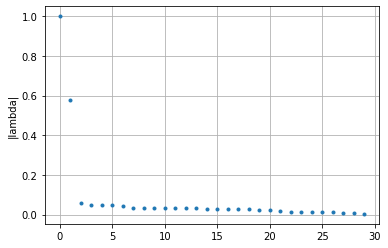

In [139]:
# eigenvalues and RIGHT eigenvectors of the Transition matrix
Teigvals,TReigvecs=np.linalg.eig(trans)

idx=(np.abs(Teigvals)).argsort()[::-1]   
Teigvals=Teigvals[idx]
TReigvecs=TReigvecs[:,idx]

# eigenvalues and LEFT eigenvectors of the Transition matrix
Teigvals,TLeigvecs=np.linalg.eig(trans.T) 
idx=(np.abs(Teigvals)).argsort()[::-1]   
Teigvals=Teigvals[idx]
TLeigvecs=TLeigvecs[:,idx]

print(Teigvals)
plt.plot(np.abs(Teigvals),'.')
plt.ylabel('|lambda|')
plt.grid(axis='both')
plt.show()

In [140]:
## check of the eigenvectors:
## 1). the sum of the components of all the left eigvectors (except the first) is zero
idx=(np.abs(Teigvals)).argsort()[::-1]   
Teigvals=Teigvals[idx]
TLeigvecs=TLeigvecs[:,idx]
print('sum components left eigvecs:\n',np.sum(TLeigvecs,axis=0))

## 2). the first right eigenvector is (1...1), except for a numerical factor
print('first right eigvec:\n', TReigvecs[:,0])

## 3). ortogonality: compute the inner product of the i-th right eigenvector and the j-th left, for i!=j is zero
## (while for i=j it is not necessarily 1, we have to impose normalization)
a=np.sum(TReigvecs[:,1]*TLeigvecs[:,0])
print('inner product:\n',a)

sum components left eigvecs:
 [ 4.89346335e+00+0.00000000e+00j -4.98906472e-15+0.00000000e+00j
  1.61155811e-15+0.00000000e+00j  1.88390969e-15+1.22298005e-16j
  1.88390969e-15-1.22298005e-16j -9.57567359e-16+0.00000000e+00j
  4.89192020e-16+0.00000000e+00j -6.93889390e-17-1.36002321e-15j
 -6.93889390e-17+1.36002321e-15j  1.74860126e-15-5.27355937e-16j
  1.74860126e-15+5.27355937e-16j  1.23512311e-15+0.00000000e+00j
  5.27355937e-16-6.10622664e-16j  5.27355937e-16+6.10622664e-16j
  4.92661467e-16+0.00000000e+00j -1.38777878e-16+6.93889390e-18j
 -1.38777878e-16-6.93889390e-18j  1.60982339e-15+4.02455846e-16j
  1.60982339e-15-4.02455846e-16j -1.45716772e-16+3.74700271e-16j
 -1.45716772e-16-3.74700271e-16j  1.79023463e-15+0.00000000e+00j
 -1.04083409e-15+6.24500451e-16j -1.04083409e-15-6.24500451e-16j
 -5.96744876e-16-4.51028104e-16j -5.96744876e-16+4.51028104e-16j
 -1.59594560e-16+0.00000000e+00j -1.38777878e-17+0.00000000e+00j
 -5.20417043e-18+0.00000000e+00j -1.10588622e-15+0.00000000e

/home/ivang/.local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


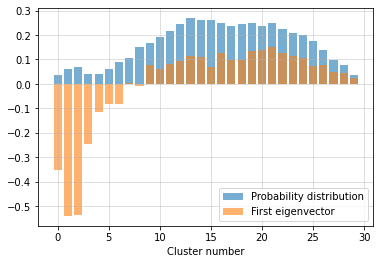

In [141]:
probDist = +TLeigvecs[:,0]/np.sum(TLeigvecs[:,0])
plt.bar(range(0,len(probDist)),TLeigvecs[:,0],alpha=0.6,label='Probability distribution')
plt.bar(range(0,len(probDist)),-TLeigvecs[:,1],alpha=0.6,label='First eigenvector')
plt.grid(alpha=0.5)
plt.xlabel('Cluster number')
plt.legend()

In [142]:
ngamma=1 # number of time scales I consider

# for any cluster, give the corresponding Markov state
A=(np.sign(np.real(TLeigvecs[0:kopt,1:ngamma+1]))+1)/2
markovst=np.zeros(kopt)
for i in range(ngamma):
    markovst=markovst+(2**i)*A[:,i]

#print(A)
del A

print(markovst)

[1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


4. Visualize the Markov states in the space of the two first principal components, or, alternatively, in the coordinates obtained by Isomap

In [143]:
def draw2(data,centroids,zcl,k):
    data1=data[:,0]
    data2=data[:,1]
    
    plt.figure(figsize=(8,6))
    for i in range(k):
        if (np.any(zcl==i)):
            plt.plot(data1[np.where(zcl==i)],data2[np.where(zcl==i)],'o',label='%i'%i,markersize=3)

    plt.plot(centroids[:,0],centroids[:,1],'*k')
    plt.title('Markov states')
    plt.legend()
    plt.show()

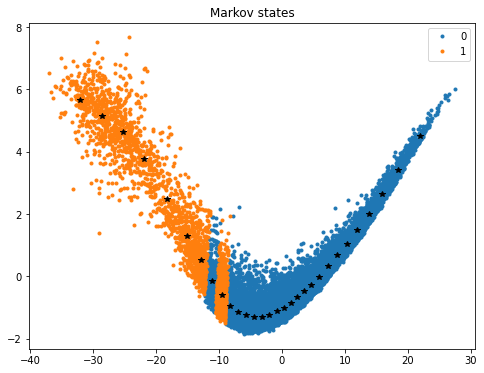

In [144]:
zMS=np.zeros(npatt)
for i in range(kopt):
    zMS[np.where(z==i)]=markovst[i]
draw2(dataPCs,centroids,zMS,2**ngamma)

5. Discuss the stability of the results with respect to the metaparameters of the approach, in particular the time lag τ and the number of clusters.

In [ ]:
N=1
ks=[5,10,20,50,100,200,500,1000]#,2000,5000]
nk=np.size(ks)

zs=np.zeros((nk,npatt))
objs=np.zeros(nk)
icount=0

for k in ks:
    objold=10**10
    for i in range(N):
        z,clusters,obj=kmeans(dataPCs,k,bplot=0)
        if (obj<objold):
            objold=obj
            [zs[icount,:],objs[icount]]=[z,obj]
    icount+=1
    print(icount)

In [23]:
# given the chosen values for tau and kopt (and the clusters):
# compute the transition matrix, its eigenvalues and right eigenvectors;
# identify which clusters belong to the same Markov states, given the number of time scales I consider

def markov(npatt,tau,kopt,z,ngamma):
    
    ndtimes=npatt-tau # i.e. how many steps t --> t+tau
    trans=np.zeros((kopt,kopt)) # the transition matrix
    ntimecl=np.zeros(kopt) # i.e. #(alpha), n. of times in clusters alpha
   
    for i in range(ndtimes):
        trans[z[i],z[i+tau]]+=1
        ntimecl[z[i]]+=1
    for i in range(kopt):
        trans[i,:]=trans[i,:]/ntimecl[i]
    
    Teigvals,TLeigvecs=np.linalg.eig(trans.T) # eigenvalues and LEFT eigenvectors of the Transition matrix (T)

    idx=(np.abs(Teigvals)).argsort()[::-1]   
    Teigvals=Teigvals[idx]
    TLeigvecs=TLeigvecs[:,idx]
    
    for i in range(1,ngamma+1): # to have the same (?) identification of the Markov states
        if (np.real(TLeigvecs[0,i])<0):
            TLeigvecs[:,i]=-TLeigvecs[:,i]
    
    A=(np.sign(np.real(TLeigvecs[0:kopt,1:ngamma+1]))+1)/2
    markovst=np.zeros(kopt)

    for i in range(ngamma):
        markovst=markovst+(2**i)*A[:,i]

    del A
    
    return trans,Teigvals[1:ngamma+1],markovst

### different time lags for the same clustering as before:

/tmp/ipykernel_11626/2317366959.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  trans[i,:,:],Teigvals[i,:],markovst[i,:]=markov(npatt,taus[i],kopt,z,ngamma)


[[  64.38140576]
 [  74.36467363]
 [  72.49480057]
 [  75.11849181]
 [  78.87363477]
 [  87.73491723]
 [ 276.06607117]
 [ 844.71336825]
 [2392.20320316]]
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1.
  1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1.
  1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1.
  1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
  1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
  1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1.
  1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1.
  1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1.
  

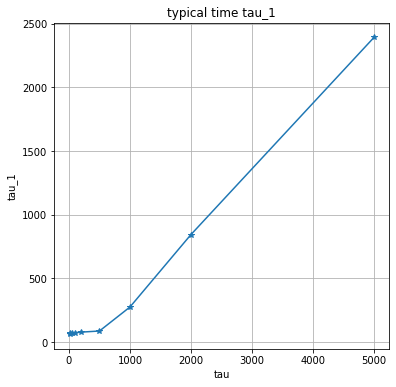

In [24]:
taus=[10,20,50,100,200,500,1000,2000,5000]
#taus=np.arange(1,150,5)
leng=np.size(taus)
trans=np.zeros((leng,kopt,kopt))
Teigvals=np.zeros((leng,ngamma))
markovst=np.zeros((leng,kopt))
typtau=np.zeros((leng,ngamma))

for i in range(leng):
    trans[i,:,:],Teigvals[i,:],markovst[i,:]=markov(npatt,taus[i],kopt,z,ngamma)
    typtau[i,:]=-taus[i]/np.log(np.abs(Teigvals[i,:]))

print(typtau)

#plt.plot()
#print(Teigvals)
print(markovst)

plt.figure(figsize=(6,6))
plt.plot(taus,typtau,'*-')
plt.title('typical time tau_1')
plt.xlabel('tau')
plt.ylabel('tau_1')
plt.grid(axis='both')
plt.show()
#plt.plot(Teigvals,'*-')

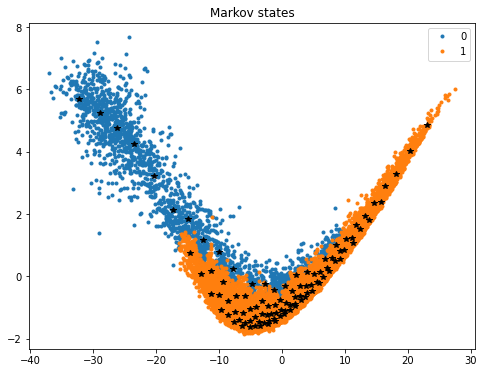

1


In [31]:
zcl=np.zeros(npatt)

a=np.random.choice(leng)

for i in range(kopt):
    zcl[np.where(z==i)]=markovst[a,i]
draw2(dataPCs,centroids,zcl,2**ngamma)
print(a)

try different clustering

In [25]:
print(ks)
print(nk)

[2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
11


In [48]:
#taus=[10,20]
taus=[2,5,10,20,50,100,200,500,1000]#,2000,5000]
#taus=np.arange(1,150,5)
leng=np.size(taus)
Teigvals=np.zeros((leng,nk,ngamma))
typtau=np.zeros((leng,nk,ngamma))
trans=np.zeros((kopt,nk))


for kopt in (ks):
    print(kopt)
    a=np.where(np.array(ks)==kopt)
    z[:]=zs[a,:]    
    
    markovst=np.zeros((leng,kopt))

    for i in range(leng):
        trans,Teigvals[i,a,:],markovst[i,:]=markov(npatt,taus[i],kopt,z,ngamma)
        typtau[i,a,:]=-taus[i]/np.log(np.abs(Teigvals[i,a,:]))

5


/tmp/ipykernel_11626/266596629.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  trans,Teigvals[i,a,:],markovst[i,:]=markov(npatt,taus[i],kopt,z,ngamma)


10
20
50
100
200
500
1000


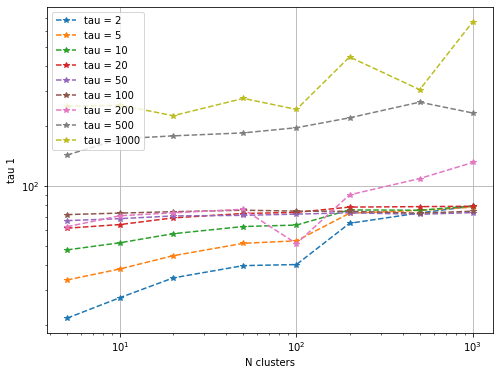

In [49]:
#print(typtau)
plt.figure(figsize=(8,6))
for i in range(leng):
    plt.plot(ks,typtau[i,:,0],'*--',label='tau = %i'%taus[i])
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('N clusters')
plt.ylabel('tau 1')
plt.grid(axis='both')

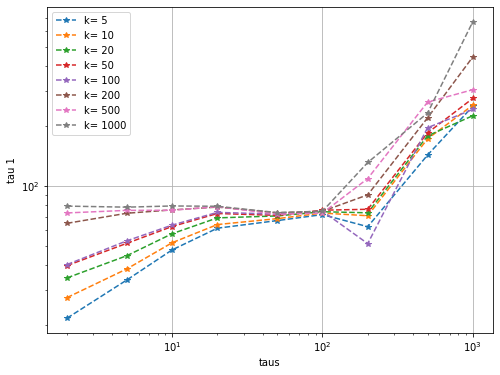

In [50]:
plt.figure(figsize=(8,6))

for j in range(nk):
    plt.plot(taus,typtau[:,j,0],'*--',label='k= %i'%ks[j])
    
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('taus')
plt.ylabel('tau 1')
plt.grid(axis='both')

6. Build a multivariate logistic regression model that predicts the Markov state from the original variables.

In [ ]:
# from dataPCs to Markov states (?)